## Import Libriaries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pwd

'/Users/jiehu/Hotel Cancellations'

In [4]:
hotel = pd.read_csv('/Users/jiehu/Hotel_bookings.csv')

In [5]:
hotel.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


## Data Cleansing
### <span style="color:blue"> 1.  Dealing with Missing Values </span>
Use a heatmap to check if there are any missing values in our data frame

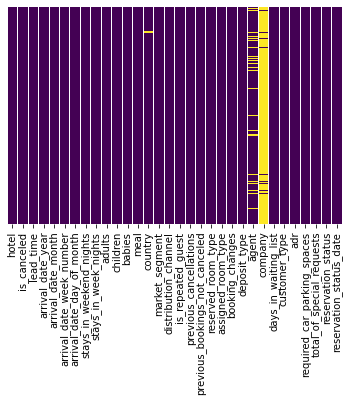

In [5]:
sns.heatmap(hotel.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There're missing values under three features:
1.['company']: Looking at the company column, it looks like we are just missing too much of that data to do something useful but just *REMOVE COLUMN*.

2.['agent']: The proportion of missing data (13.7%) is likely small enough for reasonable replacement with some form of imputation. I don't want to skew the data so decide to use the *RANDOM SAMPLING IMPUTATION* instead of MODE IMPUTATION to replace them proportionally with the existing categorical variables.

3.['country']: The missing data is very small (<5%) so I'll just *REMOVE ROWS OF MISSING VALUES*.

### 1.1 Generate random values of variable 'agent' to fill null.

In [7]:
new_agent = hotel['agent'].dropna() #get a series of just the available values
n_null = hotel['agent'].isnull().sum() #length of the missing entries

In [8]:
new_agent.sample(n_null,replace=True).values #sample it with repetition

array([  6.,  15.,   9., ..., 229.,  12., 241.])

In [9]:
hotel.loc[hotel['agent'].isnull(),'agent'] = new_agent.sample(n_null,replace=True).values #filter and assign

In [10]:
hotel['agent']

0         240.0
1          40.0
2         132.0
3         304.0
4         240.0
          ...  
119385    394.0
119386      9.0
119387      9.0
119388     89.0
119389      9.0
Name: agent, Length: 119390, dtype: float64

### 1.2 Completely Remove column of 'company'.

In [11]:
hotel.drop('company',axis=1,inplace=True)

### 1.3 Remove rows with missing values for 'country' column.

In [12]:
hotel.dropna(axis=0,inplace=True)

In [13]:
hotel.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

## Now nulls are all cleared, let's prepare dataset for Modeling!
### <span style="color:blue"> 2.  Converting Categorical Features </span>
*We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [161]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal            

**Filtering before pd.get_dummy()**: There're 12 categorical features, but I won't convert them all to dummy variables. I need to leave out those with large distinctive observations and only convert the rest. So let's check out how many unique values per feature first:

In [25]:
#create a categorical feature list
cat_feats = ['hotel','arrival_date_month','assigned_room_type','customer_type','deposit_type','distribution_channel',
             'market_segment','meal','reserved_room_type','country','reservation_status','reservation_status_date']

#make a list of unique numbers per categorical column
n_unique = hotel[cat_feats].nunique().to_list()
n_unique

[2, 12, 12, 4, 3, 5, 7, 5, 10, 177, 3, 926]

Need to leave out feature of 'country' (177 unique values) and 'reseration_status_date' (926) for the large number of unique observations.

Also need to leave out the feature of 'reservation_status' because it stated whether the booking is canceled or not.

In [16]:
#make a new list of final categorical features (9) to be convert
cat_list = ['hotel','arrival_date_month','assigned_room_type','customer_type','deposit_type','distribution_channel',
             'market_segment','meal','reserved_room_type']

**Get Dummies**

In [17]:
final_hotel = pd.get_dummies(hotel,columns=cat_list,drop_first=True)
final_hotel.drop(['country','reservation_status_date','reservation_status'],axis=1,inplace=True)

**Correlation of features with target label 'is_canceled'**

In [41]:
#calc the correlations with label column 'is_canceled'
df_corr = pd.DataFrame(final_hotel.corr()['is_canceled'])
#display top 10 features of positive correlations
df_corr.sort_values(by=['is_canceled'],ascending=False).head(10)

,is_canceled
is_canceled,1.000000
deposit_type_Non Refund,0.481349
lead_time,0.291994
market_segment_Groups,0.221538
distribution_channel_TA/TO,0.174134
customer_type_Transient,0.134473
previous_cancellations,0.109922
adults,0.058381
days_in_waiting_list,0.054016
adr,0.046199


In [42]:
#display top 10 features with negative correlations
df_corr.sort_values(by=['is_canceled']).head(10)

,is_canceled
total_of_special_requests,-0.235643
required_car_parking_spaces,-0.194796
market_segment_Direct,-0.153660
distribution_channel_Direct,-0.150900
booking_changes,-0.144659
hotel_Resort Hotel,-0.133964
assigned_room_type_D,-0.127349
customer_type_Transient-Party,-0.125436
is_repeated_guest,-0.085179
market_segment_Corporate,-0.078955


## Train Test Split

Now its time to split our data into a training set and a testing set!

In [44]:
from sklearn.model_selection import train_test_split

In [46]:
X = final_hotel.drop('is_canceled',axis=1)
y = final_hotel['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training the Random Forest model
Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rfc = RandomForestClassifier(n_estimators=100)

In [53]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

## Predictions and Evaluation

Let's predict off the y_test values and evaluate our model.

** Predict the class of is_canceled for the X_test data.**

In [54]:
pred_rfc = rfc.predict(X_test)

**Now create a classification report from the results. Do you get anything strange or some sort of warning?**

In [55]:
from sklearn.metrics import classification_report,confusion_matrix

In [56]:
print(confusion_matrix(y_test,pred_rfc))
print('')
print(classification_report(y_test,pred_rfc))

[[21028  1499]
 [ 3143 10000]]

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     22527
           1       0.87      0.76      0.81     13143

    accuracy                           0.87     35670
   macro avg       0.87      0.85      0.86     35670
weighted avg       0.87      0.87      0.87     35670



# Choosing a value of n_estimators
Let's go ahead and use the below method to pick a good value of n_estimator!

** I'll try two methods to look for the right n_estimators: 1) Create a for loop that trains various Random Forest models with different n_estimators, then keep track of the error_rate for each of these models with a list. 2) GridSearchCV**

**1) Error Rate Method:**

In [ ]:
error_rate = []
for i in range(1,300):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

**Second thought on choosing n_estimator: The more trees the more it exptected to train. Therefore, should not test every single numbers but limit my experiments and do it in big increments, like i in range(10,100,200,300)** 

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1,300),error_rate,linestyle='--',marker='o',markerfacecolor='red')

In [61]:
er_rate = []
for i in [50,100,125,150,200,250]:
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    er_rate.append(np.mean(pred_i != y_test))

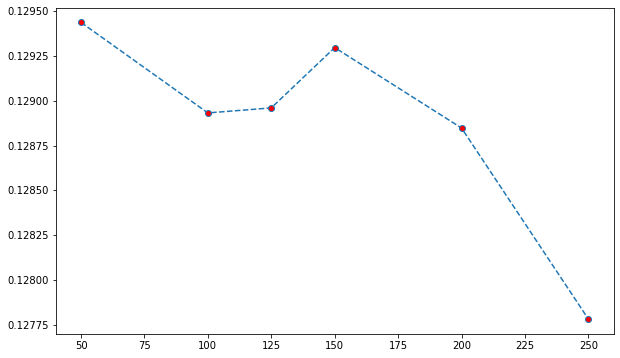

In [63]:
plt.figure(figsize=(10,6))
plt.plot([50,100,125,150,200,250],er_rate,linestyle='--',marker='o',markerfacecolor='red')

**2) GridSearch method:**

**Predefine hyperparameters: Create a dictionary called param_grid and fill out parameters for n_estimators:**

In [64]:
param_grid = {'n_estimators':[50,100,125,150,200,250]}

**Initiate the rfc model:**

In [65]:
rf_c = RandomForestClassifier()

**Create a GridSearchCV object and fit it to the training data:**

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
grid = GridSearchCV(estimator=rf_c,param_grid=param_grid,verbose=2) #verbose=the text output describing the process

In [68]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=50, total=   6.6s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] .................................. n_estimators=50, total=   8.5s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   7.5s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.9s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   7.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  15.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  13.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  13.5s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.7min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 125, 150, 200, 250]},
             verbose=2)

In [69]:
grid.best_params_

{'n_estimators': 250}

## Retrain with new n_estimator Value

**Retrain your model with the best n_estimator value (up to you to decide what you want) and re-do the classification report and the confusion matrix.**

In [70]:
rfc = RandomForestClassifier(n_estimators=250)
rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)

In [71]:
print(confusion_matrix(y_test,pred))
print('')
print(classification_report(y_test,pred))

[[21024  1503]
 [ 3134 10009]]

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     22527
           1       0.87      0.76      0.81     13143

    accuracy                           0.87     35670
   macro avg       0.87      0.85      0.86     35670
weighted avg       0.87      0.87      0.87     35670



**Feature Importance**

In [77]:
list(zip(final_hotel.columns,rfc.feature_importances_))

[('is_canceled', 0.14009958610931467),
 ('lead_time', 0.019979785004370868),
 ('arrival_date_year', 0.05285972907279855),
 ('arrival_date_week_number', 0.06503702840146938),
 ('arrival_date_day_of_month', 0.02752175842033394),
 ('stays_in_weekend_nights', 0.04288658054940345),
 ('stays_in_week_nights', 0.015379398896419365),
 ('adults', 0.006561176689870701),
 ('children', 0.0010129513708943528),
 ('babies', 0.002295293951851459),
 ('is_repeated_guest', 0.040018823035574226),
 ('previous_cancellations', 0.0037385197714242735),
 ('previous_bookings_not_canceled', 0.022534959520683285),
 ('booking_changes', 0.0518485745293888),
 ('agent', 0.003740865739401705),
 ('days_in_waiting_list', 0.08851778374662415),
 ('adr', 0.021013968470746987),
 ('required_car_parking_spaces', 0.06343509010858868),
 ('total_of_special_requests', 0.009489992506941821),
 ('hotel_Resort Hotel', 0.005534466409615837),
 ('arrival_date_month_August', 0.002674893838019511),
 ('arrival_date_month_December', 0.0035166

## <span style="color:red"> *----------------End!!----------------* </span>